# Monte Carlo simulation for multi-asset portfolio( Use NVDA, APPL, Ford, BAC for example)

Author: Yvonne Hsu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from datetime import date, timedelta, datetime
from time import time
import seaborn as sns
sns.set()
import yfinance as yf

### Specify your portfolio

Here, I choose NVDA, a growing tech company; AAPL, a steadily growing tech company; and Ford and BAC for stable investments.

In [2]:
symbols=['NVDA','AAPL','F','BAC']

Download historical closing prices for specified symbols from 2019-12-31 to 2024-08-31. 

Including the last day of 2019 allows for accurate calculation of returns starting from 2020

In [3]:
hist_data = yf.download(symbols, start='2019-12-31', end=date.today(), interval='1d')['Close']

[*********************100%***********************]  4 of 4 completed


In [4]:
hist_data

Ticker,AAPL,BAC,F,NVDA
Date,,,,
2019-12-31 00:00:00+00:00,73.412498,35.220001,9.30,5.882500
2020-01-02 00:00:00+00:00,75.087502,35.639999,9.42,5.997750
2020-01-03 00:00:00+00:00,74.357498,34.900002,9.21,5.901750
2020-01-06 00:00:00+00:00,74.949997,34.849998,9.16,5.926500
2020-01-07 00:00:00+00:00,74.597504,34.619999,9.25,5.998250
...,...,...,...,...
2024-09-20 00:00:00+00:00,228.199997,40.270000,10.88,116.000000
2024-09-23 00:00:00+00:00,226.470001,39.869999,10.91,116.260002
2024-09-24 00:00:00+00:00,227.369995,39.450001,10.87,120.870003


In [5]:
# calculate return
daily_return = hist_data.pct_change()

daily_return.dropna()

Ticker,AAPL,BAC,F,NVDA
Date,,,,
2020-01-02 00:00:00+00:00,0.022816,0.011925,0.012903,0.019592
2020-01-03 00:00:00+00:00,-0.009722,-0.020763,-0.022293,-0.016006
2020-01-06 00:00:00+00:00,0.007968,-0.001433,-0.005429,0.004194
2020-01-07 00:00:00+00:00,-0.004703,-0.006600,0.009825,0.012107
2020-01-08 00:00:00+00:00,0.016086,0.010110,0.000000,0.001876
...,...,...,...,...
2024-09-20 00:00:00+00:00,-0.002927,-0.014681,-0.003663,-0.015865
2024-09-23 00:00:00+00:00,-0.007581,-0.009933,0.002757,0.002241
2024-09-24 00:00:00+00:00,0.003974,-0.010534,-0.003666,0.039653


## Mean, Covariance

In [6]:
Mean = pd.DataFrame(list(np.mean(daily_return[i]) for i in daily_return.columns), 
                    index=daily_return.columns, columns = ['avg_return'])
Mean

,avg_return
Ticker,
AAPL,0.001156
BAC,0.000356
F,0.000521
NVDA,0.003148


In [7]:
covMatrix = daily_return.cov()
covMatrix

Ticker,AAPL,BAC,F,NVDA
Ticker,,,,
AAPL,0.000413,0.000196,0.000215,0.000430
BAC,0.000196,0.000522,0.000379,0.000253
F,0.000215,0.000379,0.000811,0.000350
NVDA,0.000430,0.000253,0.000350,0.001185


## Assumption: Principal, Weights, Number of Trial

Here we set the initial investment amount (principal) and the allocation weights for each stock.

In this example, we've assigned equal weights to all four stocks.

In [8]:
principal=1000
weights = [1/len(symbols)] * len(symbols)

Here we set the simulation conditions. A higher number of trials will yield more accurate results but require more time.

The simulation period equals the timeframe you want to forecast. In this case, 30 represents 30 trading days, indicating we want to predict the value one month later.

In [9]:
number_of_trial = 100
sim_period = 30

## Monte Carlo Method

In [10]:
sim_mean = np.full(shape = (sim_period, 4), fill_value = Mean.T.loc['avg_return'])
sim_mean = sim_mean.T

In [11]:
sim_portfolio = np.full(shape = (sim_period, number_of_trial), fill_value = 0)

In [12]:
sim_portfolio.shape

(30, 100)

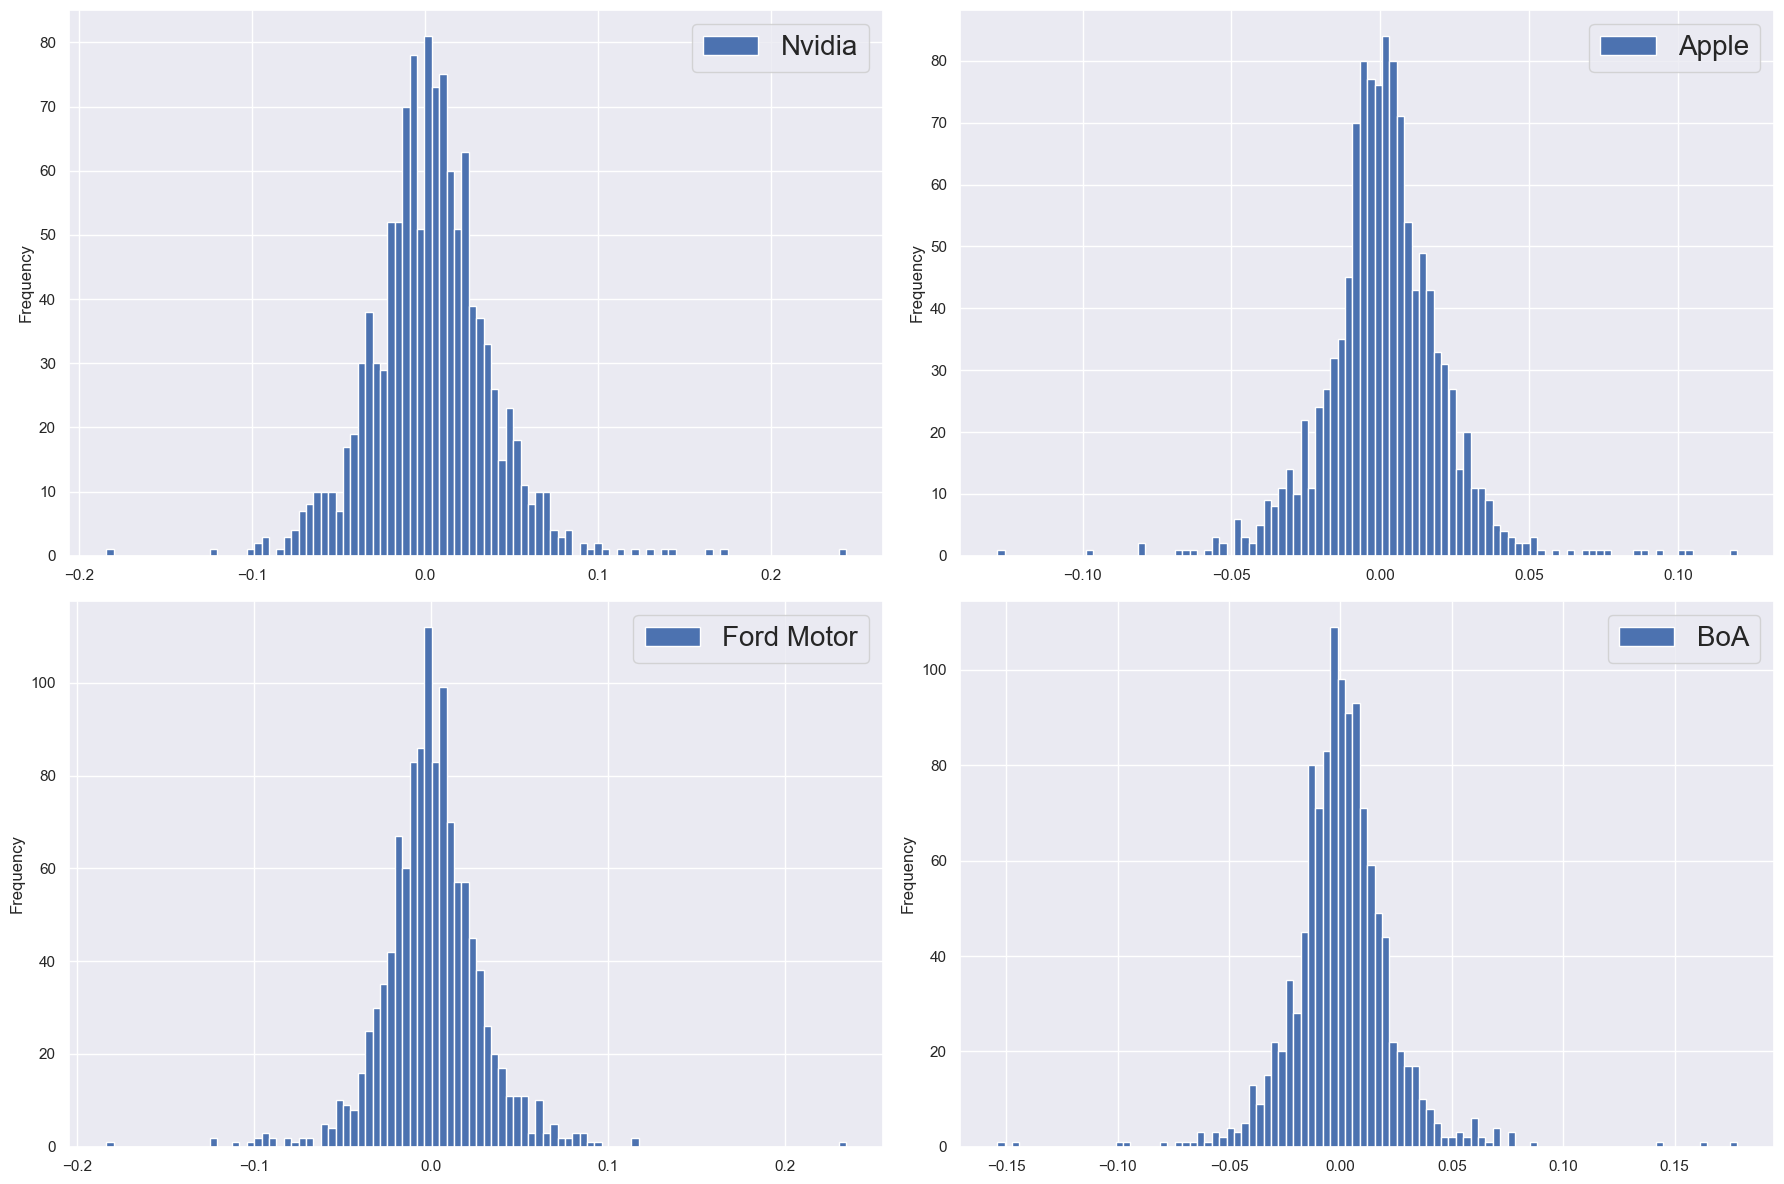

In [13]:
fig, ax =plt.subplots(figsize = (18, 12), nrows = 2, ncols = 2)

daily_return['NVDA'].plot.hist(ax=ax[0][0], bins = 100,range=(daily_return['NVDA'].min(), daily_return['NVDA'].max()),  label = 'Nvidia')
ax[0][0].legend(loc = 1, fontsize = 20)

daily_return['AAPL'].plot.hist(ax=ax[0][1], bins = 100,range=(daily_return['AAPL'].min(), daily_return['AAPL'].max()),  label = 'Apple')
ax[0][1].legend(loc = 1, fontsize = 20)

daily_return['F'].plot.hist(ax=ax[1][0], bins = 100,range=(daily_return['F'].min(), daily_return['F'].max()),  label = 'Ford Motor')
ax[1][0].legend(loc = 1, fontsize = 20)

daily_return['BAC'].plot.hist(ax=ax[1][1], bins = 100,range=(daily_return['BAC'].min(), daily_return['BAC'].max()),  label = 'BoA')
ax[1][1].legend(loc = 1, fontsize = 20)

plt.tight_layout()

From the above graphs, we can observe that the return distributions of various assets roughly approximate a normal distribution. Therefore, in the following process we use normal distribution.

Perform Cholesky decomposition on the covariance matrix
The Cholesky decomposition is used to handle correlations between assets. We then calculate simulated returns for each asset by taking the inner product of the Cholesky matrix and the random normal distributions. Finally, we compute the portfolio value by applying asset weights, compounding the returns, and scaling by the initial investment amount.

In [15]:
for i in range(0, number_of_trial):
    multi_normal = np.random.normal(size = (sim_period, 4))
    # This addresses correlations between assets in a multi-asset portfolio
    cholesky = np.linalg.cholesky(covMatrix)
    
    # Calculate simulated returns, incorporating asset correlations
    sim_return = sim_mean + np.inner(cholesky, multi_normal)
    
    # Compute the cumulative portfolio value
    # by applying asset weights, compounding returns, and scaling by initial principal
    sim_portfolio[:,i] = np.cumprod(np.inner(weights, sim_return.T) + 1) * principal

## Visualization

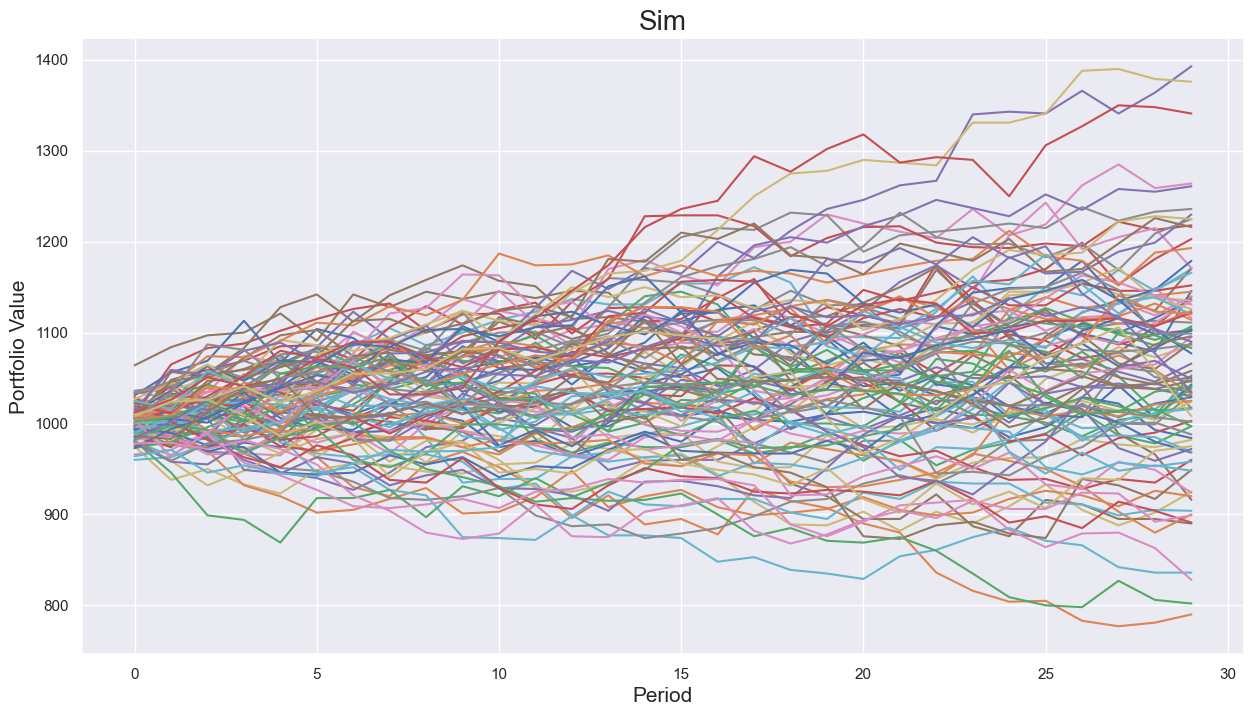

In [16]:
plt.figure(figsize=(15,8))

plt.plot(sim_portfolio)
plt.ylabel('Portfolio Value', fontsize = 15)
plt.xlabel('Period', fontsize = 15)
plt.title('Sim', fontsize = 20)
plt.show()

In [17]:
print(f'max :{np.max(sim_portfolio)}')
print(f'min :{np.min(sim_portfolio)}')
print(f'avg :''{:.1f}'.format(np.mean(sim_portfolio)))

max :1393
min :777
avg :1041.4


The Monte Carlo simulation for this portfolio over the next month yields the following insights:

- Downside Risk: The portfolio's value is not expected to fall below 777, which represents a maximum potential loss of approximately 22.3% from the initial investment of 1000. This indicates that the downside risk for the upcoming month is limited to about 40% in the worst-case scenario.

- Upside Potential: The portfolio shows a maximum potential value of 1393, which translates to a possible gain of up to 37.2% from the initial investment. This suggests significant upside potential in the best-case scenario.
Expected Performance: With an average projected value of 1041.4, the portfolio is expected to yield a modest positive return of about 4.14% over the next month.

- Given these projections, investors should be prepared for potential volatility. While there's a chance for substantial gains, there's also a risk of moderate losses. This portfolio might be suitable for investors with a moderate to high risk tolerance who are comfortable with short-term fluctuations in pursuit of potential gains. However, the significant downside risk should be carefully considered.